# GRU Gated Recurrent Unit
### Using Tensorflow

## Imports

In [9]:
from utilities.std_imports import *
from numpy import random
import tensorflow as tf

## Utils

In [10]:
# Converts an integer to a reversed bitstring of specified size. E.g.: asBytes(3, 4) = [1, 1, 0, 0]; asBytes(3, 5) = [1, 1, 0, 0, 0]
def AsBytes(num, size):
    res = []
    for _ in range(size):
        res.append(num % 2)
        num //= 2
    return res

# Generate example addition. a (1st term), b (2nd term), c (addition a+b). All represented as reversed strings
def GenExample(nBits):
    a = random.randint(0, 2**(nBits - 1) - 1)
    b = random.randint(0, 2**(nBits - 1) - 1)
    res = a + b
    return (AsBytes(a,  nBits),
            AsBytes(b,  nBits),
            AsBytes(res,nBits))

# Generate batchSize instances of the addition problem. x: 2 numbers to be added, y: addition result (all b: bit index from the end, i: idx, n [0,1] for terms, 0 for result.
def GenBatch(nBits, batchSize):
    x = np.empty((batchSize, nBits, 2))
    y = np.empty((batchSize, nBits, 1))

    for i in range(batchSize):
        a, b, r = GenExample(nBits)
        x[i, :, 0] = a
        x[i, :, 1] = b
        y[i, :, 0] = r
    return x, y



## GRU

In [11]:
class GRU:
    def __init__(self, inpDim, hidDim, dtype=tf.float64):
        self.inpDim = inpDim
        self.hidDim = hidDim
        
        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.inpDim, self.hidDim), mean=0, stddev=0.01), name='Wr')
        self.Wz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.inpDim, self.hidDim), mean=0, stddev=0.01), name='Wz')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.inpDim, self.hidDim), mean=0, stddev=0.01), name='Wh')
        
        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidDim, self.hidDim), mean=0, stddev=0.01), name='Ur')
        self.Uz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidDim, self.hidDim), mean=0, stddev=0.01), name='Uz')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidDim, self.hidDim), mean=0, stddev=0.01), name='Uh')
        
        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidDim,), mean=0, stddev=0.01), name='br')
        self.bz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidDim,), mean=0, stddev=0.01), name='bz')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(self.hidDim,), mean=0, stddev=0.01), name='bh')
        
        # Define the input layer placeholder
        self.inpLay = tf.placeholder(dtype=tf.float64, shape=(None, None, inpDim), name='input')
        
        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.inpLay, [1, 0, 2], name='x_t')
        
        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(dtype=tf.float64, shape=(inpDim, hidDim)), name='h_0')
        
        # Perform the scan operator
        self.h_t_transposed = tf.scan(self.Forward, self.x_t, initializer=self.h_0, name='h_t_transposed')
        
        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    # Forward pass : h_tm1 previous hidden state, x_t input vector
    def Forward(self, h_tm1, x_t):
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(tf.matmul(x_t, self.Wz) + tf.matmul(h_tm1, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_tm1, self.Ur) + self.br)
        
        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)
        
        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)
        
        return h_t

## Testing

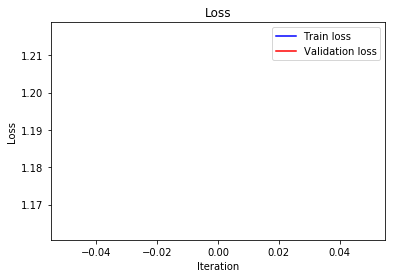

Iteration: 0, train loss: 1.2162, test loss: 1.1632


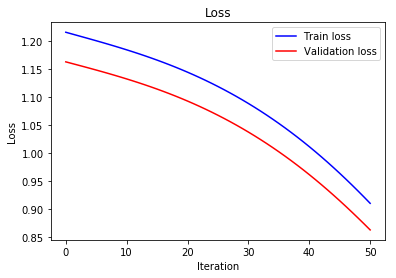

Iteration: 50, train loss: 0.9100, test loss: 0.8624


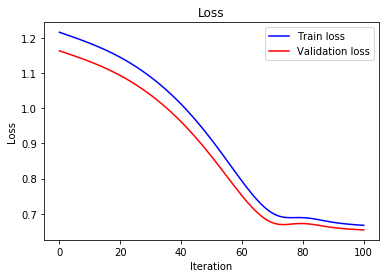

Iteration: 100, train loss: 0.6669, test loss: 0.6539


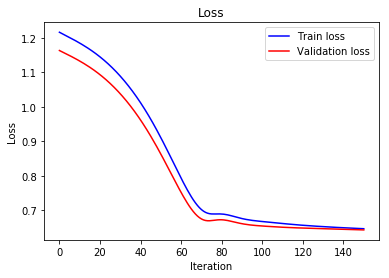

Iteration: 150, train loss: 0.6461, test loss: 0.6426


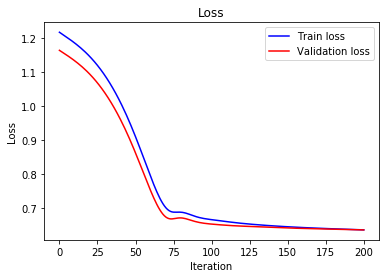

Iteration: 200, train loss: 0.6370, test loss: 0.6369


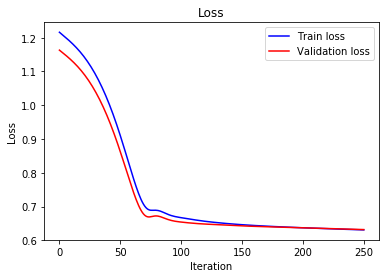

Iteration: 250, train loss: 0.6307, test loss: 0.6317


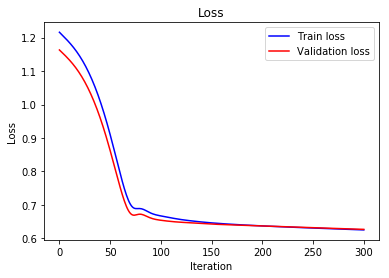

Iteration: 300, train loss: 0.6251, test loss: 0.6267


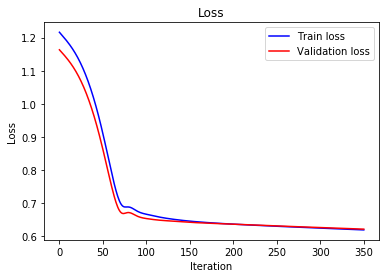

Iteration: 350, train loss: 0.6196, test loss: 0.6220


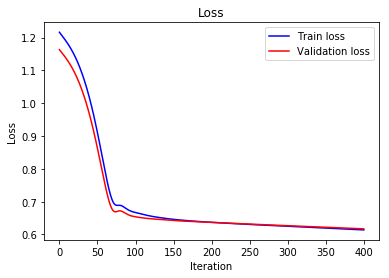

Iteration: 400, train loss: 0.6139, test loss: 0.6172


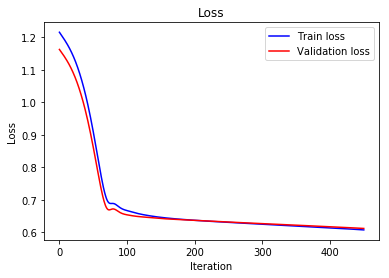

Iteration: 450, train loss: 0.6074, test loss: 0.6120


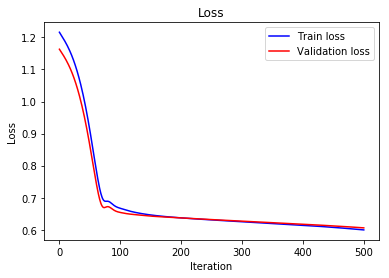

Iteration: 500, train loss: 0.5995, test loss: 0.6058


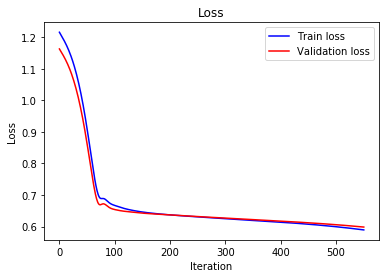

Iteration: 550, train loss: 0.5893, test loss: 0.5984


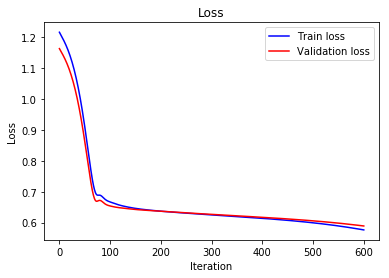

Iteration: 600, train loss: 0.5764, test loss: 0.5892


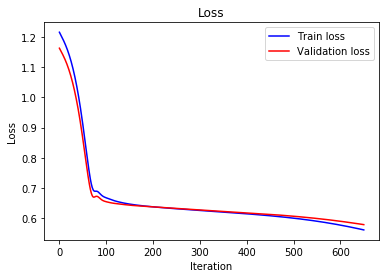

Iteration: 650, train loss: 0.5605, test loss: 0.5780


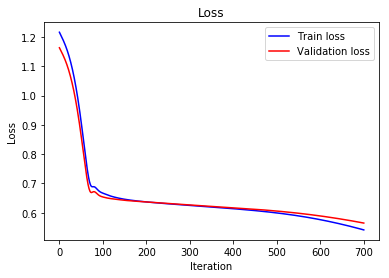

Iteration: 700, train loss: 0.5415, test loss: 0.5649


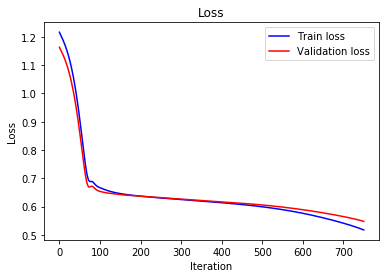

Iteration: 750, train loss: 0.5178, test loss: 0.5480


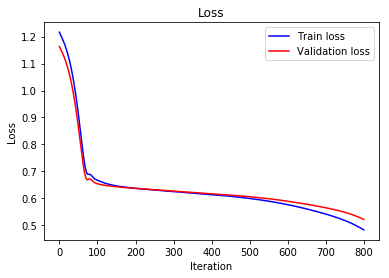

Iteration: 800, train loss: 0.4826, test loss: 0.5214


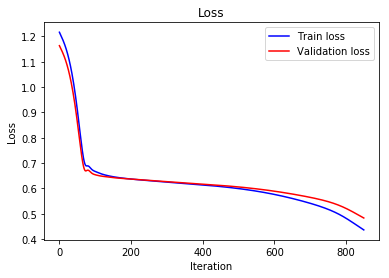

Iteration: 850, train loss: 0.4363, test loss: 0.4833


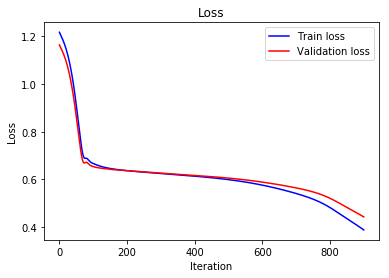

Iteration: 900, train loss: 0.3890, test loss: 0.4433


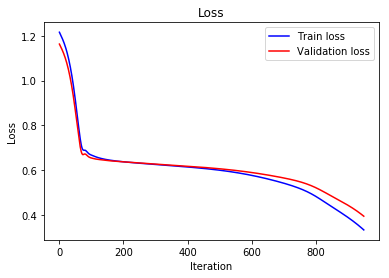

Iteration: 950, train loss: 0.3325, test loss: 0.3938


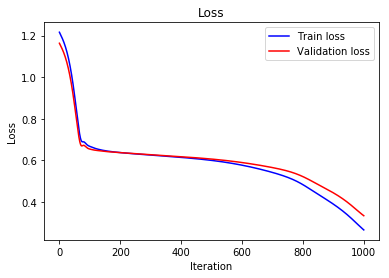

Iteration: 1000, train loss: 0.2649, test loss: 0.3332


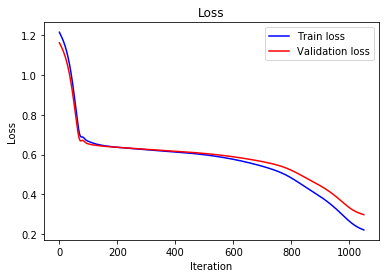

Iteration: 1050, train loss: 0.2209, test loss: 0.2979


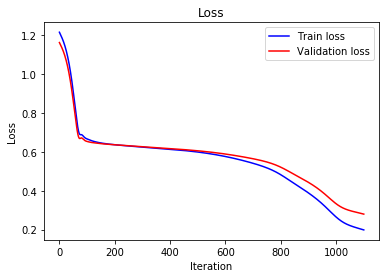

Iteration: 1100, train loss: 0.1985, test loss: 0.2799


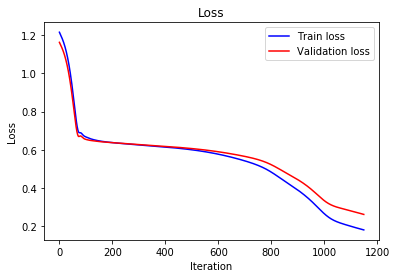

Iteration: 1150, train loss: 0.1789, test loss: 0.2602


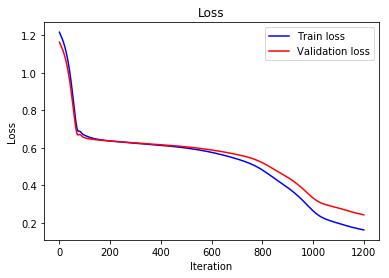

Iteration: 1200, train loss: 0.1634, test loss: 0.2438


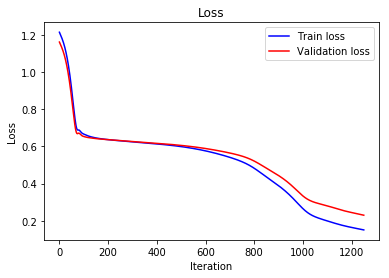

Iteration: 1250, train loss: 0.1501, test loss: 0.2294


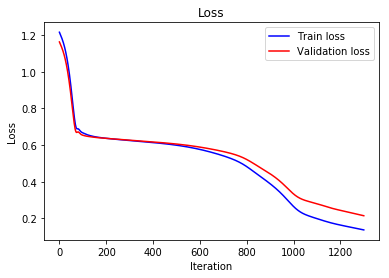

Iteration: 1300, train loss: 0.1369, test loss: 0.2144


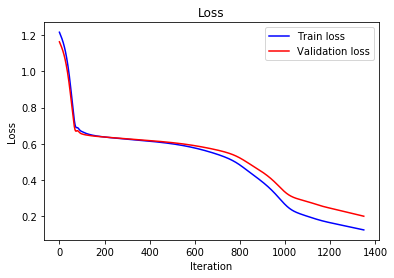

Iteration: 1350, train loss: 0.1233, test loss: 0.1990


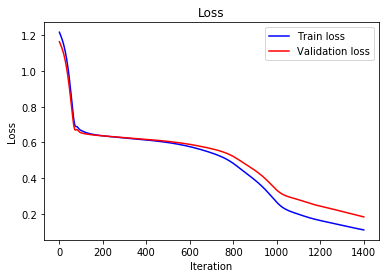

Iteration: 1400, train loss: 0.1110, test loss: 0.1838


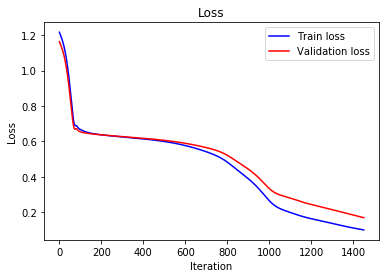

Iteration: 1450, train loss: 0.1001, test loss: 0.1694


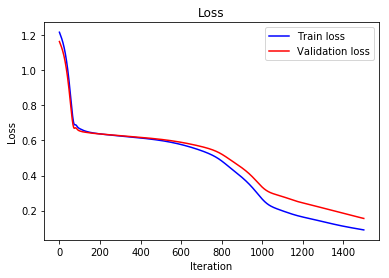

Iteration: 1500, train loss: 0.0900, test loss: 0.1554


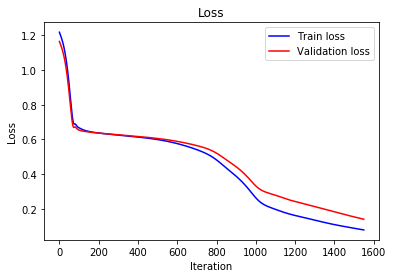

Iteration: 1550, train loss: 0.0804, test loss: 0.1417


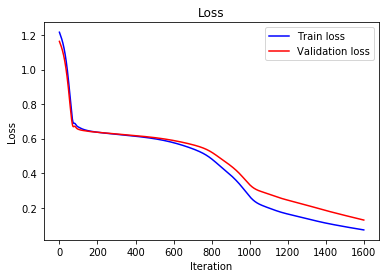

Iteration: 1600, train loss: 0.0713, test loss: 0.1284


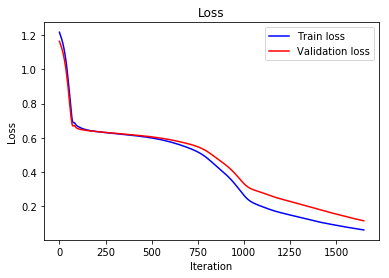

Iteration: 1650, train loss: 0.0629, test loss: 0.1161


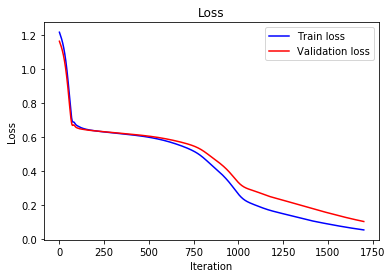

Iteration: 1700, train loss: 0.0552, test loss: 0.1046


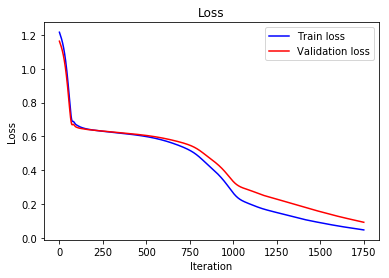

Iteration: 1750, train loss: 0.0475, test loss: 0.0926


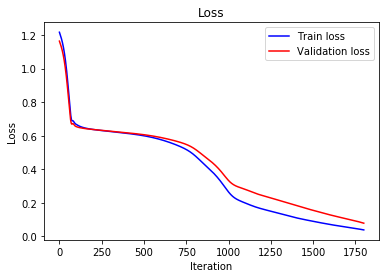

Iteration: 1800, train loss: 0.0388, test loss: 0.0789


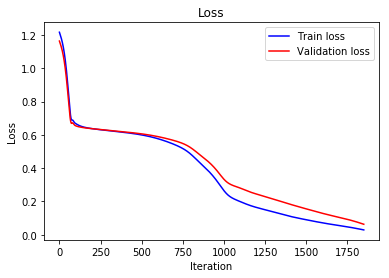

Iteration: 1850, train loss: 0.0290, test loss: 0.0630


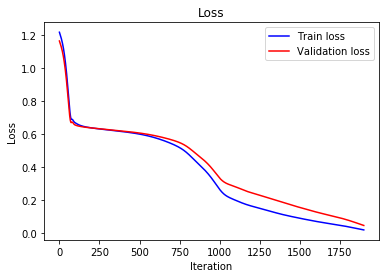

Iteration: 1900, train loss: 0.0193, test loss: 0.0463


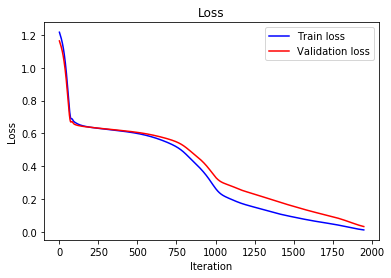

Iteration: 1950, train loss: 0.0117, test loss: 0.0323


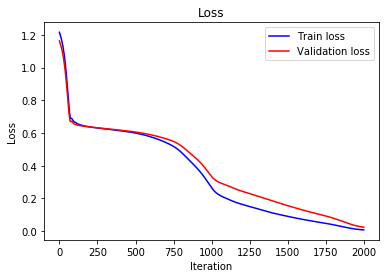

Iteration: 2000, train loss: 0.0072, test loss: 0.0238


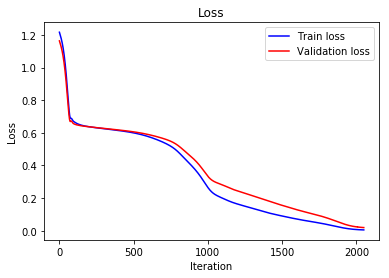

Iteration: 2050, train loss: 0.0049, test loss: 0.0192


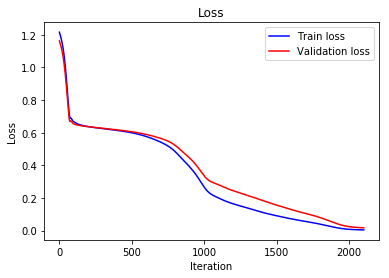

Iteration: 2100, train loss: 0.0036, test loss: 0.0165


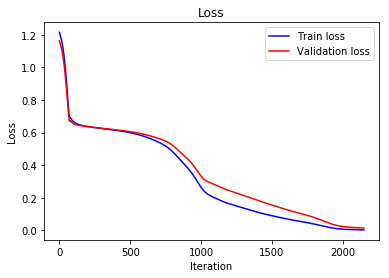

Iteration: 2150, train loss: 0.0028, test loss: 0.0145


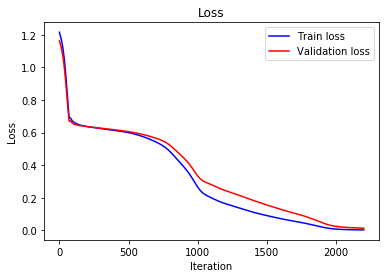

Iteration: 2200, train loss: 0.0023, test loss: 0.0127


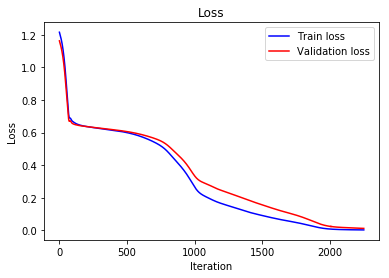

Iteration: 2250, train loss: 0.0018, test loss: 0.0112


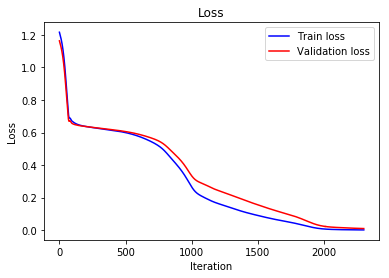

Iteration: 2300, train loss: 0.0015, test loss: 0.0099


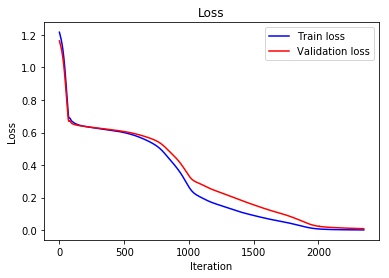

Iteration: 2350, train loss: 0.0013, test loss: 0.0089


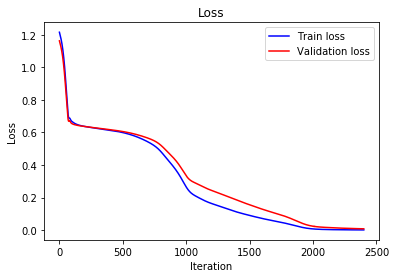

Iteration: 2400, train loss: 0.0011, test loss: 0.0080


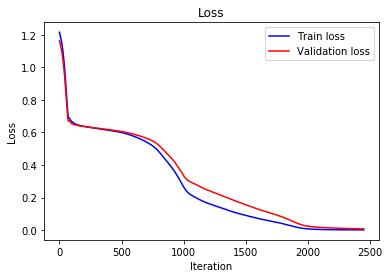

Iteration: 2450, train loss: 0.0010, test loss: 0.0073


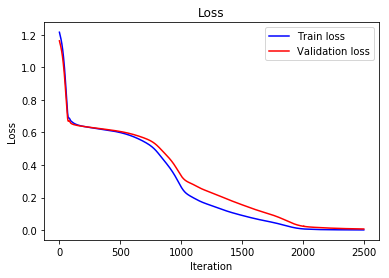

Iteration: 2500, train loss: 0.0009, test loss: 0.0067


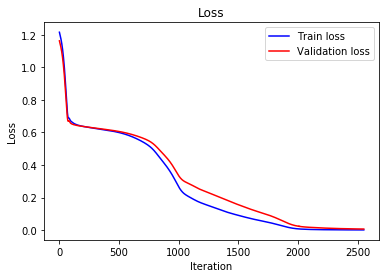

Iteration: 2550, train loss: 0.0008, test loss: 0.0062


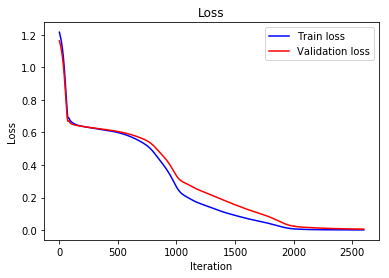

Iteration: 2600, train loss: 0.0007, test loss: 0.0058


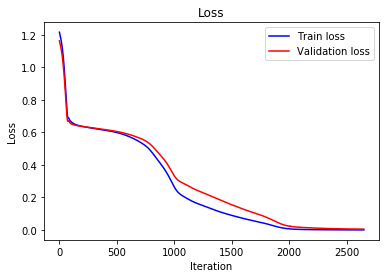

Iteration: 2650, train loss: 0.0006, test loss: 0.0055


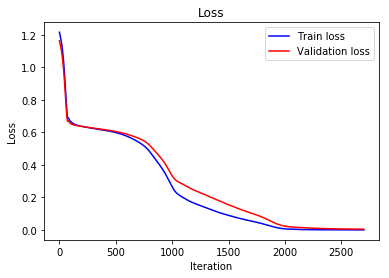

Iteration: 2700, train loss: 0.0006, test loss: 0.0052


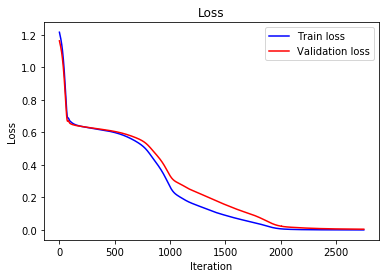

Iteration: 2750, train loss: 0.0005, test loss: 0.0050


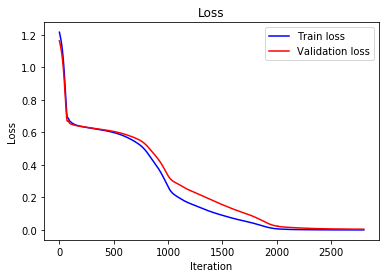

Iteration: 2800, train loss: 0.0005, test loss: 0.0048


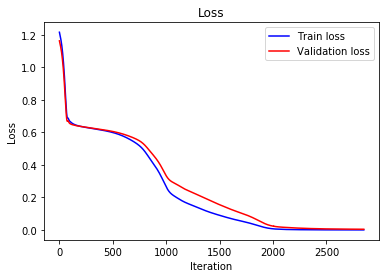

Iteration: 2850, train loss: 0.0005, test loss: 0.0046


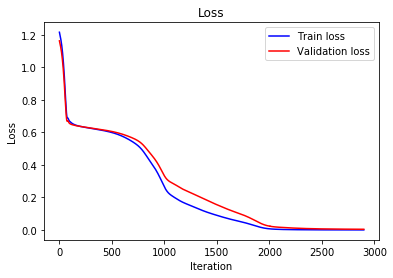

Iteration: 2900, train loss: 0.0004, test loss: 0.0044


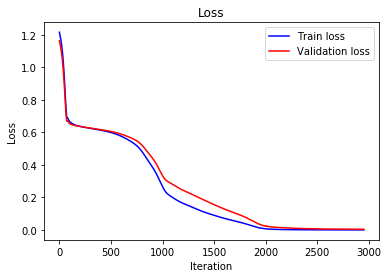

Iteration: 2950, train loss: 0.0004, test loss: 0.0043


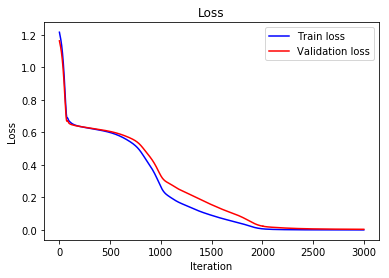

Iteration: 3000, train loss: 0.0004, test loss: 0.0041


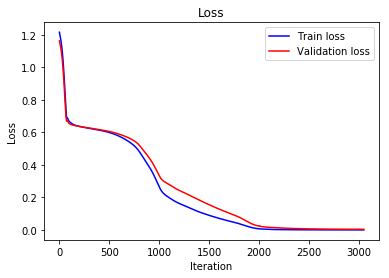

Iteration: 3050, train loss: 0.0003, test loss: 0.0040


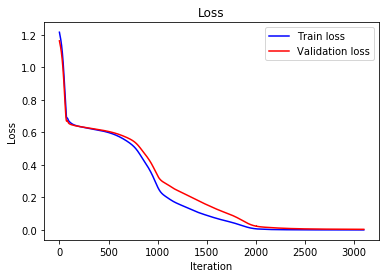

Iteration: 3100, train loss: 0.0003, test loss: 0.0039


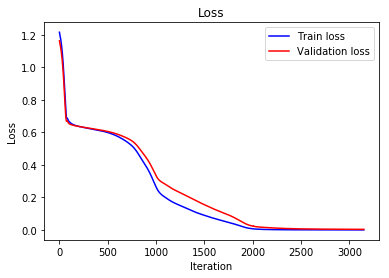

Iteration: 3150, train loss: 0.0003, test loss: 0.0038


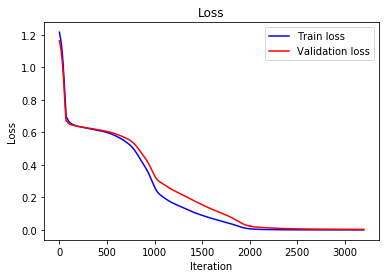

Iteration: 3200, train loss: 0.0003, test loss: 0.0038


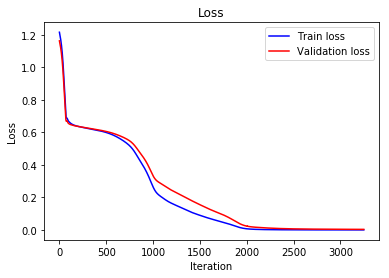

Iteration: 3250, train loss: 0.0003, test loss: 0.0036


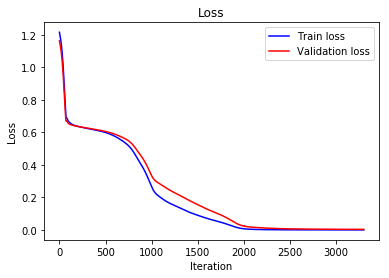

Iteration: 3300, train loss: 0.0002, test loss: 0.0036


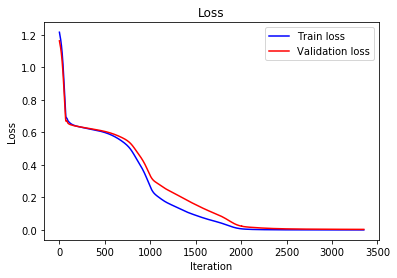

Iteration: 3350, train loss: 0.0002, test loss: 0.0035


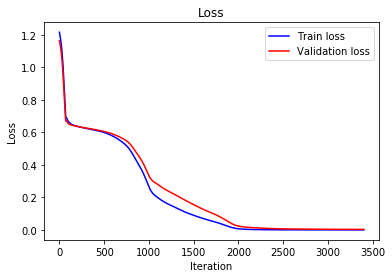

Iteration: 3400, train loss: 0.0002, test loss: 0.0034


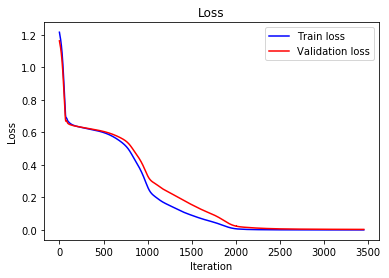

Iteration: 3450, train loss: 0.0002, test loss: 0.0033


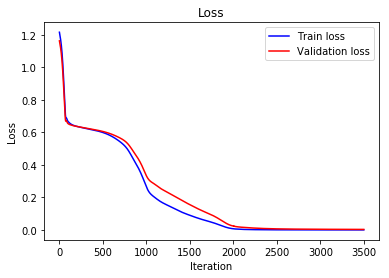

Iteration: 3500, train loss: 0.0002, test loss: 0.0033


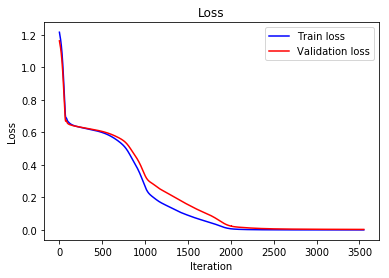

Iteration: 3550, train loss: 0.0002, test loss: 0.0032


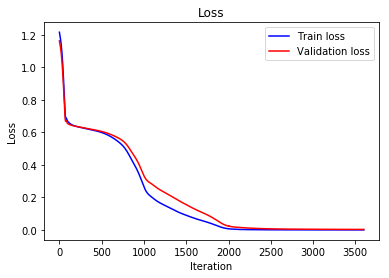

Iteration: 3600, train loss: 0.0002, test loss: 0.0032


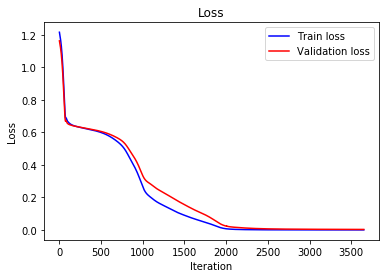

Iteration: 3650, train loss: 0.0002, test loss: 0.0031


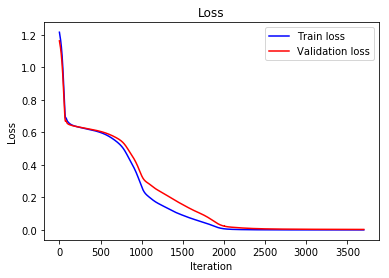

Iteration: 3700, train loss: 0.0002, test loss: 0.0031


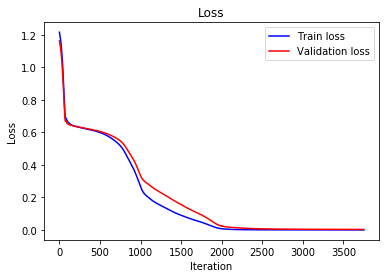

Iteration: 3750, train loss: 0.0001, test loss: 0.0030


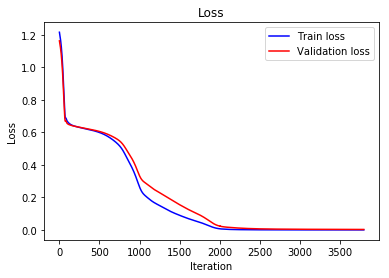

Iteration: 3800, train loss: 0.0001, test loss: 0.0030


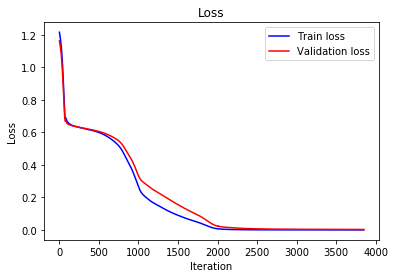

Iteration: 3850, train loss: 0.0001, test loss: 0.0029


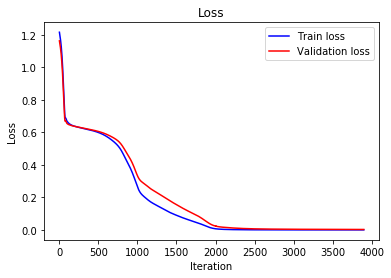

Iteration: 3900, train loss: 0.0002, test loss: 0.0029


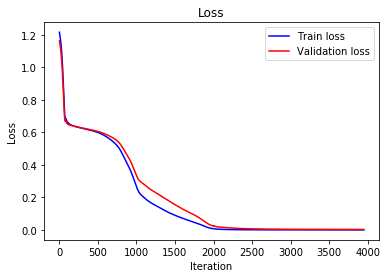

Iteration: 3950, train loss: 0.0001, test loss: 0.0028


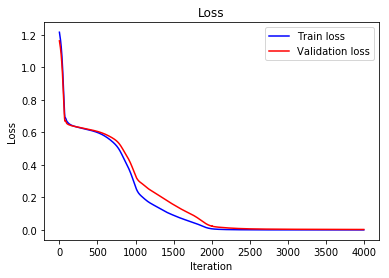

Iteration: 4000, train loss: 0.0001, test loss: 0.0028


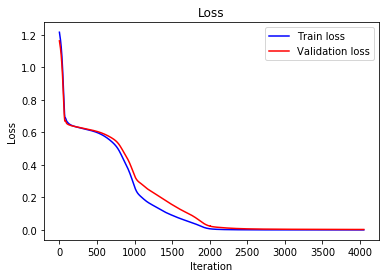

Iteration: 4050, train loss: 0.0001, test loss: 0.0028


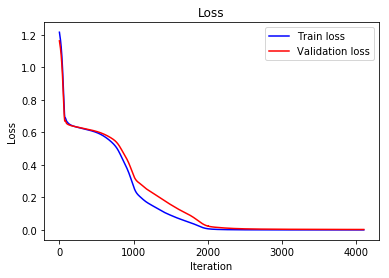

Iteration: 4100, train loss: 0.0001, test loss: 0.0027


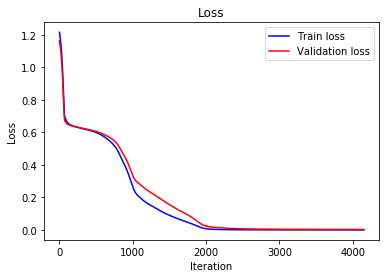

Iteration: 4150, train loss: 0.0001, test loss: 0.0027


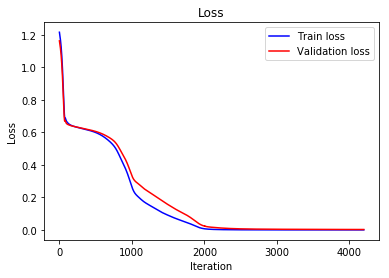

Iteration: 4200, train loss: 0.0001, test loss: 0.0027


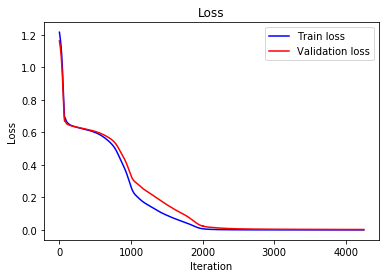

Iteration: 4250, train loss: 0.0001, test loss: 0.0026


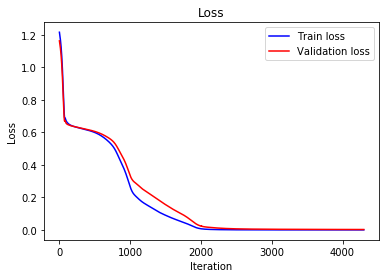

Iteration: 4300, train loss: 0.0001, test loss: 0.0026


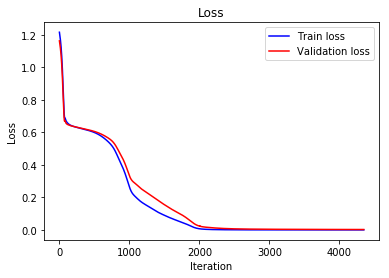

Iteration: 4350, train loss: 0.0001, test loss: 0.0026


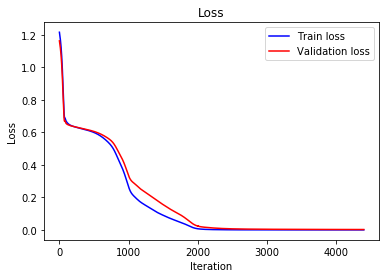

Iteration: 4400, train loss: 0.0001, test loss: 0.0026


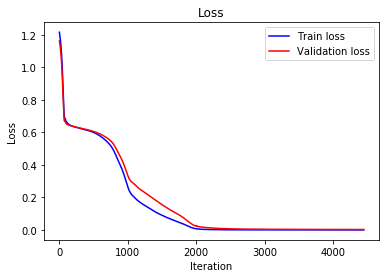

In [ ]:
# 1. Dataset creation (100 examples of numbers represented in 5 bits)
batchSize = 100
timeSize = 5
Xtrain, Ytrain = GenBatch(timeSize, batchSize)
Xtest, Ytest = GenBatch(timeSize, batchSize)

# 2. Create Model
inpDim = 2 # for each term 
hidDim = 16


gru = GRU(inpDim, hidDim)
Wout = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidDim, 1), mean=0, stddev=0.01))
bout = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
output = tf.map_fn(lambda h_t: tf.matmul(h_t, Wout) + bout, gru.h_t)

# Expected output & loss
expOutput = tf.placeholder(dtype=tf.float64, shape=(batchSize, timeSize, 1), name='expected_output')
loss = tf.reduce_sum(0.5 * tf.pow(output - expOutput, 2)) / float(batchSize)

trainStep = tf.train.AdamOptimizer().minimize(loss)

# Initialize
session = tf.Session()
init = tf.global_variables_initializer()
session.run(init)
trainLoss = []
validLoss = []

# 2. Train
for epoch in range(5000):
    # Compute the losses
    _, train_loss = session.run([trainStep, loss], feed_dict={gru.inpLay: Xtrain, expOutput: Ytrain})
    validation_loss = session.run(loss, feed_dict={gru.inpLay: Xtest, expOutput: Ytest})
    
    # Log the losses
    trainLoss += [train_loss]
    validLoss += [validation_loss]
    
    # Display an update every 50 iterations
    if epoch % 50 == 0:
        plt.plot(trainLoss, '-b', label='Train loss')
        plt.plot(validLoss, '-r', label='Validation loss')
        plt.legend(loc=0)
        plt.title('Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Iteration: %d, train loss: %.4f, test loss: %.4f' % (epoch, train_loss, validation_loss))
    

    
# Define two numbers a and b and let the model compute a + b
a = 1024
b = 16

# The model is independent of the sequence length! Now we can test the model on even longer bitstrings
bitstring_length = 20

# Create the feature vectors    
X_custom_sample = np.vstack([AsBytes(a, bitstring_length), AsBytes(b, bitstring_length)]).T
X_custom = np.zeros((1,) + X_custom_sample.shape)
X_custom[0, :, :] = X_custom_sample

# Make a prediction by using the model
y_predicted = session.run(output, feed_dict={gru.inpLay: X_custom})
# Just use a linear class separator at 0.5
y_bits = 1 * (y_predicted > 0.5)[0, :, 0]
# Join and reverse the bitstring
y_bitstr = ''.join([str(int(bit)) for bit in y_bits.tolist()])[::-1]
# Convert the found bitstring to a number
y = int(y_bitstr, 2)

# Print out the prediction
print(y) # Yay! This should equal 1024 + 16 = 1040